In [1]:
import os
import sys 
os.chdir("/workspaces/dev")
sys.path.append("/workspaces/dev/modules")

In [ ]:
from matplotlib import pyplot as plt
import pandas as pd
from pathlib import Path
from math import ceil, floor

In [3]:
from Pills.Utils import *

2025-03-07 09:51:28.696613: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-07 09:51:28.706534: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741341088.716928     479 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741341088.719967     479 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-07 09:51:28.731624: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [4]:
SOURCE_PATH = 'datasets/pills/data'
LABEL_PATH = 'datasets/pills/class_label.csv'

In [59]:
def readImage(path:Path):
  img = cv2.imread(str(path), cv2.IMREAD_UNCHANGED)
  img = cv2.cvtColor(img, cv2.COLOR_BGRA2RGBA)
  if img.shape[2] != 4:
    print(f"Error: {path}")
  return img
  # img = cv2.cvtColor(img, cv2.COLOR_BGRA2RGBA)
  # alpha_channel = img[:, :, 3]
  # rgb_image = img[:, :, :3]
  # background_mask = (alpha_channel == 0)
  # rgb_image[background_mask, :] = 0
  # return rgb_image

In [6]:
def draw_label_box(img, ly, lx, ry, rx, text, color=(0, 255, 0, 255), thickness=1):
  cv2.rectangle(img, (lx, ly), (rx, ry), color, thickness)

  text_size = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 2)[0]
  if ly - text_size[1] - 5 < 0:
    text_x, text_y = lx, ry + text_size[1]
    background_lx, background_ly = lx, ry
    background_rx, background_ry = rx, ry + text_size[1] + 5
  else:
    text_x, text_y = lx, ly - text_size[1]//2
    background_lx, background_ly = lx, ly - text_size[1] - 5
    background_rx, background_ry = rx, ly
    
  cv2.rectangle(img, (background_lx, background_ly), (background_rx, background_ry), color, -1)
  cv2.putText(img, text, (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255, 0, 0, 255), thickness, cv2.LINE_AA)

In [7]:
def show(img, size=10):
  plt.figure(figsize=(size, size))
  plt.imshow(img)
  plt.show()

In [8]:
def show_images_grid(images, cols=5, spacing=0.01):
  n = len(images)
  rows = n // cols + (1 if n % cols != 0 else 0)
  fig, axes = plt.subplots(rows, cols, figsize=(cols*5, rows*5))
  for i, img in enumerate(images):
    ax = axes[i // cols, i % cols]
    ax.imshow(img)
    ax.axis('off')
  for i in range(n, rows*cols):
    fig.delaxes(axes.flatten()[i])
  plt.subplots_adjust(wspace=spacing, hspace=spacing)
  plt.show()

In [9]:
class_label = pd.read_csv(LABEL_PATH, header=0)

In [49]:
pills_dict = {row['class']: row['label'].strip() for _, row in class_label.iterrows()}

In [50]:
len(pills_dict)

50

In [51]:
pills_folder = Path(SOURCE_PATH)

In [61]:
pill_imgs_dict = {
  pills_dict[c.stem] : [readImage(img) for img in c.iterdir() if img.suffix == '.png']
  for c in pills_folder.iterdir()
}

In [62]:
# show_images_grid(next(iter(pill_imgs_dict.items()))[1])

In [63]:
BACKGROUND_SHAPE = (1024, 1024, 4)

In [64]:
all_imgs = [img for imgs in pill_imgs_dict.values() for img in imgs ]

In [65]:
img_label = [(img, label) for label, imgs in pill_imgs_dict.items() for img in imgs]

In [87]:
def annotation_test(background:np.ndarray, img_label:list[tuple[np.ndarray, str]]):
  test_imgs = random.sample(img_label, random.randint(1, 20))
  test_imgs = [(rotate(img[0], np.random.randint(0, 360)), img[1]) for img in test_imgs]
  test_imgs.sort(key=lambda x: x[0].shape[0] * x[0].shape[1], reverse=True)
  objects, labels = zip(*test_imgs)
  objects = list(objects)
  labels = list(labels)
  positions = generate_position(background, objects, max_try = 10, padding = 100)
  if not positions:
    return annotation_test(background, img_label)
  temp = list(zip(objects, positions))
  random.shuffle(temp)
  objects, positions = zip(*temp)
  objects = list(objects)
  labels = list(labels)
  img = draw_at_position(background, objects, positions)
  mask = mask_at_position(background, objects, positions)
  centroids = centroid_at_mask(mask)
  bboxes = bbox_at_mask(mask)
  return img, zip(objects, labels, centroids, bboxes)

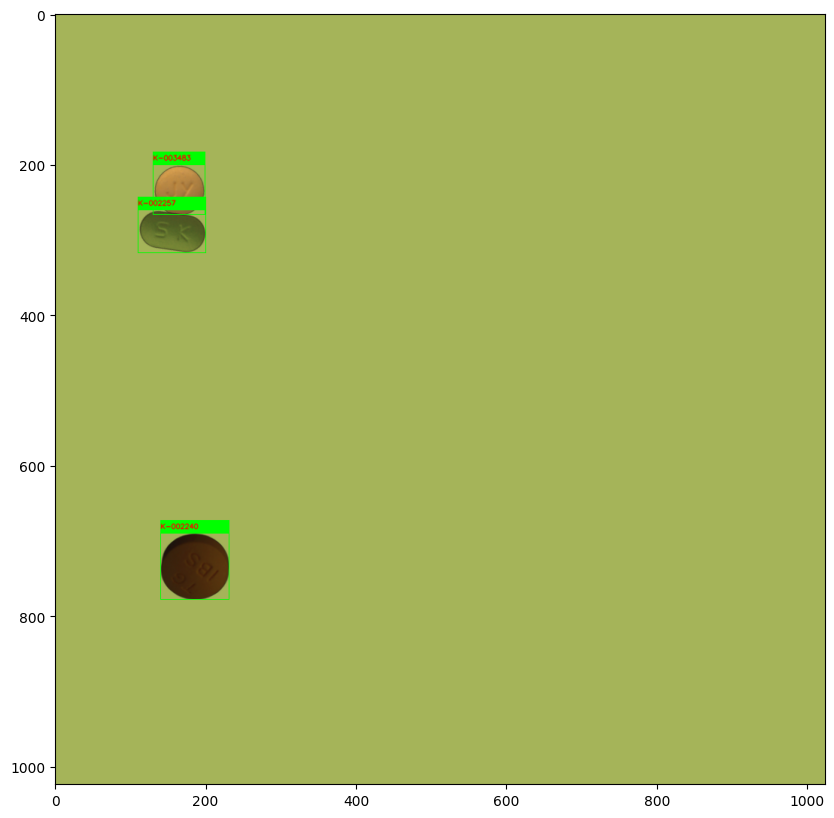

In [97]:
img, annotation = annotation_test(random_color_background(BACKGROUND_SHAPE), img_label)
for ann in annotation:
  draw_label_box(img, *ann[3], ann[1]) 
show(img)

In [29]:
def test(background:np.ndarray, all_imgs:list[np.ndarray]):
  test_imgs = random.sample(all_imgs, random.randint(1, 20))
  objects = [rotate(img, np.random.randint(0, 360)) for img in test_imgs]
  objects.sort(key=lambda obj: obj.shape[0]*obj.shape[1], reverse=True)
  positions = generate_position(background, objects, max_try = 1, padding=100)
  if not positions:
    return test(background, all_imgs)
  background = draw_at_position(background, objects, positions)
  # show(background)

In [30]:
# for _ in range(1000): # 1000장 생성에 1분 24초 소요 됨. 1 코어, 1 장당 0.084초
#   test(np.zeros(BACKGROUND_SHAPE, dtype=np.uint8), all_imgs)

In [31]:
test(random_color_background(BACKGROUND_SHAPE), all_imgs)

In [32]:
BACKGROUND_IMAGES_PATH = 'data'

In [63]:
background_path = Path(BACKGROUND_IMAGES_PATH)

In [66]:
background_images = [readImage(img) for img in background_path.iterdir() if img.suffix == '.png' or img.suffix == '.jpg']

In [88]:
new_background_images = []
for img in background_images:
  if img.shape[0] < BACKGROUND_SHAPE[0] or img.shape[1] < BACKGROUND_SHAPE[1]:
    new_background_images.append(cv2.resize(img, (BACKGROUND_SHAPE[1], BACKGROUND_SHAPE[0]), interpolation=cv2.INTER_LANCZOS4))
background_images = new_background_images

In [95]:
def random_position_background(background_images:list[np.ndarray], min_size:int = BACKGROUND_SHAPE[0]):
  bkg_imgs = background_images.copy()
  random.shuffle(bkg_imgs)

  while bkg_imgs:
    background = bkg_imgs.pop()
    if background.shape[0] >= min_size and background.shape[1] >= min_size:
      h, w, _ = background.shape
      row = np.random.randint(0, h - min_size + 1)
      col = np.random.randint(0, w - min_size + 1)
      return background[row:row+min_size, col:col+min_size]

In [96]:
test(random_position_background(background_images), all_imgs)

In [97]:
def gaussian_blur(image, ksize=5):
  return cv2.GaussianBlur(image, (ksize, ksize), 0)

In [98]:
def random_noise(image, mean=0, std=10):
  noise = np.random.normal(mean, std, image.shape).astype(np.uint8)
  noisy = cv2.add(image, noise)
  return noisy

In [99]:
def feather_edges(image, background, mask, feather_amount=11):
    mask = cv2.GaussianBlur(mask.astype(np.float32), (feather_amount, feather_amount), 0)
    blended = (image * mask[:, :, np.newaxis] + background * (1 - mask[:, :, np.newaxis])).astype(np.uint8)

    return blended

In [100]:
def expand_and_blur_mask(mask, expansion=5, blur_amount=11):
  kernel = np.ones((expansion, expansion), np.uint8)
  expanded_mask = cv2.dilate(mask.astype(np.uint8), kernel, iterations=1)
  return gaussian_blur(expanded_mask, blur_amount)

In [101]:
def add_shadow(image, background, mask, shadow_intensity=0.5):
    shadow_mask = expand_and_blur_mask(mask, expansion=11, blur_amount=21)
    shadow = (shadow_mask * shadow_intensity * 255).astype(np.uint8)

    # ✅ 1채널(Grayscale) → 3채널(RGB) 변환
    if background.shape[-1] == 3:  # RGB 배경
        shadow = cv2.cvtColor(shadow, cv2.COLOR_GRAY2BGR)
    elif background.shape[-1] == 4:  # RGBA 배경
        shadow = cv2.cvtColor(shadow, cv2.COLOR_GRAY2BGRA)

    # ✅ 이제 크기와 채널이 맞아서 정상 동작!
    shadowed_background = cv2.addWeighted(background, 1, shadow, 0.5, 0)

    return feather_edges(image, shadowed_background, mask)

In [102]:
def blend_with_texture(image, background, alpha=0.7):
  blended = cv2.addWeighted(image, alpha, background, 1 - alpha, 0)
  return blended

In [157]:
def test2(background:np.ndarray, all_imgs:list[np.ndarray]):
  test_imgs = random.sample(all_imgs, 8)
  objects = [rotate(img, np.random.randint(0, 360)) for img in test_imgs]
  objects.sort(key=lambda obj: obj.shape[0]*obj.shape[1], reverse=True)
  positions = generate_position(background, objects, max_try = 1, padding=100)
  if not positions:
    return test2(background, all_imgs)
  return draw_at_position(background, objects, positions), mask_at_position(background, objects, positions), centroid_at_position(background, objects, positions), bbox_at_position(background, objects, positions)

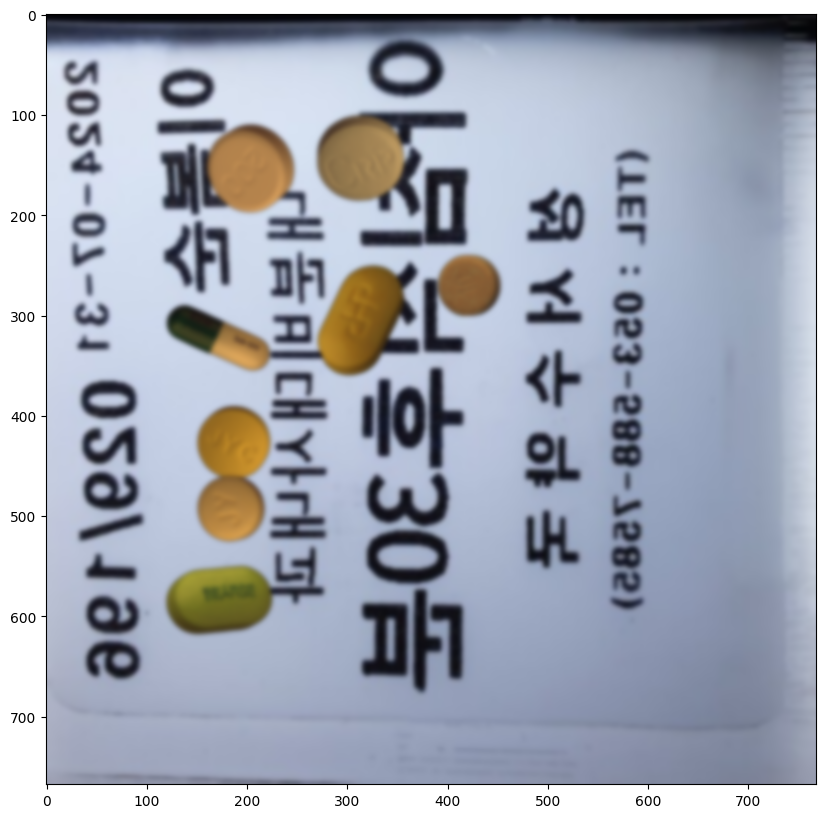

In [203]:
background = random_position_background(background_images)
background = cv2.resize(background, (int(background.shape[0] * 0.75), int(background.shape[1] * 0.75)), interpolation=cv2.INTER_LANCZOS4)
img, mask, centroid, bbox = test2(background, all_imgs)
# img = random_noise(img, mean=0.3, std=0.7)
# img = blend_with_texture(img, background, alpha=0.9)
# img = feather_edges(img, background, mask, feather_amount=5)
img = gaussian_blur(img, ksize=13)
# img = add_shadow(img, background, mask, shadow_intensity=0.04o)
show(img)